In [1]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import sklearn as skl
import sklearn.utils
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.svm
import librosa
import librosa.display
import madmom
from tqdm import tqdm
import pickle
import ffmpeg

import utils

plt.rcParams['figure.figsize'] = (17, 5)

In [2]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')

# Load metadata and features.
tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """


((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [15]:
tracks.columns

MultiIndex(levels=[['album', 'artist', 'set', 'track'], ['active_year_begin', 'active_year_end', 'associated_labels', 'bio', 'bit_rate', 'comments', 'composer', 'date_created', 'date_recorded', 'date_released', 'duration', 'engineer', 'favorites', 'genre_top', 'genres', 'genres_all', 'id', 'information', 'interest', 'language_code', 'latitude', 'license', 'listens', 'location', 'longitude', 'lyricist', 'members', 'name', 'number', 'producer', 'publisher', 'related_projects', 'split', 'subset', 'tags', 'title', 'tracks', 'type', 'website', 'wikipedia_page']],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [5, 7, 9, 11, 12, 16, 17, 22, 29, 34, 35, 36, 37, 0, 1, 2, 3, 5, 7, 12, 16, 20, 23, 24, 26, 27, 31, 34, 38, 39, 32, 33, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 17, 18, 19, 21, 22, 25, 28, 30, 34, 35]])

In [55]:
tracks['track'].columns

Index(['bit_rate', 'comments', 'composer', 'date_created', 'date_recorded',
       'duration', 'favorites', 'genre_top', 'genres', 'genres_all',
       'information', 'interest', 'language_code', 'license', 'listens',
       'lyricist', 'number', 'publisher', 'tags', 'title'],
      dtype='object')

In [19]:
tracks['track', 'genre_top'].head(2)

track_id
2    Hip-Hop
3    Hip-Hop
Name: (track, genre_top), dtype: category
Categories (16, object): [Blues, Classical, Country, Easy Listening, ..., Pop, Rock, Soul-RnB, Spoken]

In [6]:
tracks[(tracks['track', 'genre_top'] == 'Jazz')].head(5)

album                                                           \
         comments        date_created date_released engineer favorites  id   
track_id                                                                     
144             0 2008-11-26 01:50:07    2009-01-06      NaN         0  64   
145             0 2008-11-26 01:50:07    2009-01-06      NaN         0  64   
146             0 2008-11-26 01:50:13    1995-01-01      NaN         1  65   
147             0 2008-11-26 01:50:13    1995-01-01      NaN         1  65   
237             0 2008-11-26 01:55:00    2003-01-11      NaN         3  94   

                                                                     \
                                                information listens   
track_id                                                              
144       <p><em>A</em>lthough recorded in Providence in...    2014   
145       <p><em>A</em>lthough recorded in Providence in...    2014   
146       <p>"Excellent accordion oriented avant-prog ba...    1446   
147       <p>"Excellent accordion oriented avant-prog ba...    1446   
237                                                     NaN    2544   

                             ...       track                         \
              producer tags  ... information interest language_code   
track_id                     ...                                      
144       Tom Buckland   []  ...         NaN     1146            en   
145       Tom Buckland   []  ...         NaN      968            en   
146                NaN   []  ...         NaN      855            en   
147                NaN   []  ...         NaN      930            en   
237                NaN   []  ...         NaN     1391            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
144       Attribution-Noncommercial-No Derivative Works ...    1143      NaN   
145       Attribution-Noncommercial-No Derivative Works ...     883      NaN   
146       Attribution-Noncommercial-No Derivative Works ...     690      NaN   
147       Attribution-Noncommercial-No Derivative Works ...     766      NaN   
237       Attribution-NonCommercial-NoDerivatives (aka M...    1276      NaN   

                                                                              
         number publisher tags                                         title  
track_id                                                                      
144           1       NaN   []                                       Wire Up  
145           3       NaN   []                                    Amoebiasis  
146           6       NaN   []  Gimme a Buck or I'll Touch You / Boilermaker  
147           7       NaN   []                    Repetitive Motion Sickness  
237           7       NaN   []                Garbage and (Garbage and Fire)  

[5 rows x 52 columns]

In [51]:
filename = utils.get_audio_path(AUDIO_DIR, 11861)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

File: ./data/fma_large/011/011861.mp3


/mnt/d/bobotran/anaconda3/envs/fma/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.98s, 1321967 samples


In [52]:
proc = madmom.features.beats.DBNBeatTrackingProcessor(fps=100)
act = madmom.features.beats.RNNBeatProcessor()(filename)

beat_times = proc(act)

clicks = librosa.clicks(beat_times, sr=sr, length=len(x))
output = x + clicks
ipd.Audio(output[start*sr:27*sr], rate=sr)

In [74]:
act[:50]

array([0.10220404, 0.2382349 , 0.23423217, 0.07295375, 0.01702511,
       0.00602643, 0.00235371, 0.00099844, 0.00055344, 0.00041749,
       0.00040942, 0.00048553, 0.00067463, 0.00102848, 0.00157359,
       0.00266524, 0.00504186, 0.00996761, 0.02189702, 0.05287385,
       0.13456216, 0.13803498, 0.07212337, 0.03617571, 0.02005535,
       0.01136214, 0.00674577, 0.00408756, 0.00268749, 0.00200921,
       0.00147579, 0.0010161 , 0.0007937 , 0.00067989, 0.00066009,
       0.00073837, 0.00089292, 0.00114049, 0.00161638, 0.00262284,
       0.00473424, 0.00880677, 0.01604563, 0.0319093 , 0.06475208,
       0.14906825, 0.3572739 , 0.35179973, 0.15430224, 0.06254097],
      dtype=float32)

In [79]:
act[45]

0.14906825

In [53]:
beat_times

array([ 0.2 ,  0.6 ,  0.99,  1.4 ,  1.78,  2.19,  2.56,  2.95,  3.35,
        3.75,  4.14,  4.53,  4.93,  5.33,  5.72,  6.12,  6.52,  6.91,
        7.31,  7.72,  8.1 ,  8.49,  8.87,  9.28,  9.67, 10.08, 10.46,
       10.87, 11.26, 11.64, 12.02, 12.44, 12.83, 13.23, 13.62, 14.01,
       14.41, 14.81, 15.18, 15.59, 15.99, 16.4 , 16.78, 17.19, 17.57,
       17.97, 18.35, 18.75, 19.15, 19.55, 19.94, 20.33, 20.73, 21.14,
       21.52, 21.92, 22.31, 22.71, 23.1 , 23.49, 23.89, 24.28, 24.69,
       25.08, 25.47, 25.87, 26.26, 26.66, 27.05, 27.45, 27.83, 28.23,
       28.62, 29.02, 29.41, 29.83])

In [28]:
pd.__version__

'0.24.0'

In [50]:
print(len(tracks[tracks['track', 'genres'].str.contains(539, regex=False)]))
tracks[tracks['track', 'genres'].str.contains(539, regex=False)]['track'].head(5)

638


bit_rate  comments composer        date_created date_recorded  \
track_id                                                                  
11861       280892         0      NaN 2009-04-30 16:06:30           NaT   
11862       296427         0      NaN 2009-04-30 16:06:31           NaT   
11863       291182         0      NaN 2009-04-30 16:06:32           NaT   
11864       286642         0      NaN 2009-04-30 16:06:33           NaT   
11865       293163         0      NaN 2009-04-30 16:06:34           NaT   

          duration  favorites genre_top     genres genres_all information  \
track_id                                                                    
11861          132          1   Hip-Hop  [21, 539]  [539, 21]         NaN   
11862          224          2   Hip-Hop  [21, 539]  [539, 21]         NaN   
11863          170          1   Hip-Hop  [21, 539]  [539, 21]         NaN   
11864          108          0   Hip-Hop  [21, 539]  [539, 21]         NaN   
11865          219          0   Hip-Hop  [21, 539]  [539, 21]         NaN   

          interest language_code  \
track_id                           
11861         2507            en   
11862         2653            en   
11863         2220            en   
11864         2630            en   
11865         1424            en   

                                                    license  listens lyricist  \
track_id                                                                        
11861     Attribution-Noncommercial-Share Alike 3.0 Unit...     1289      NaN   
11862     Attribution-Noncommercial-Share Alike 3.0 Unit...     1243      NaN   
11863     Attribution-Noncommercial-Share Alike 3.0 Unit...      772      NaN   
11864     Attribution-Noncommercial-Share Alike 3.0 Unit...      893      NaN   
11865     Attribution-Noncommercial-Share Alike 3.0 Unit...      821      NaN   

          number publisher tags  \
track_id                          
11861          6       NaN   []   
11862          5       NaN   []   
11863          9       NaN   []   
11864          1       NaN   []   
11865          8       NaN   []   

                                                      title  
track_id                                                     
11861                                  Nike Boots Freestyle  
11862     05 A-Trak &amp; Lupe Fiasco feat. 6th Sense - ...  
11863      Ignite The People (Like Obama) {prod. 6th Sense}  
11864                                                 Intro  
11865     08 Let's Do It (prod. 6th Sense &amp; Frequenc...

In [44]:
len(tracks[(tracks['track','genre_top'] == 'Jazz')])

571

In [3]:
filtered_genres = tracks[(tracks['track','genre_top'] == 'Jazz') | 
#            (tracks['track','genre_top'] == 'Classical') |
           tracks['track', 'genres'].str.contains(539, regex=False)]
len(filtered_genres)

1209

In [17]:
tracks['track'].head(5)

bit_rate  comments   composer        date_created date_recorded  \
track_id                                                                    
2           256000         0        NaN 2008-11-26 01:48:12    2008-11-26   
3           256000         0        NaN 2008-11-26 01:48:14    2008-11-26   
5           256000         0        NaN 2008-11-26 01:48:20    2008-11-26   
10          192000         0  Kurt Vile 2008-11-25 17:49:06    2008-11-26   
20          256000         0        NaN 2008-11-26 01:48:56    2008-01-01   

          duration  favorites genre_top     genres         genres_all  \
track_id                                                                
2              168          2   Hip-Hop       [21]               [21]   
3              237          1   Hip-Hop       [21]               [21]   
5              206          6   Hip-Hop       [21]               [21]   
10             161        178       Pop       [10]               [10]   
20             311          0       NaN  [76, 103]  [17, 10, 76, 103]   

         information  interest language_code  \
track_id                                       
2                NaN      4656            en   
3                NaN      1470            en   
5                NaN      1933            en   
10               NaN     54881            en   
20               NaN       978            en   

                                                    license  listens lyricist  \
track_id                                                                        
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...     1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...      514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...     1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...    50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...      361      NaN   

          number publisher tags            title  
track_id                                          
2              3       NaN   []             Food  
3              4       NaN   []     Electric Ave  
5              6       NaN   []       This World  
10             1       NaN   []          Freeway  
20             3       NaN   []  Spiritual Level

In [4]:
def get_beat_feature(track_id):
    filename = utils.get_audio_path(AUDIO_DIR, track_id)
    x, sr = librosa.load(filename, sr=None, mono=True)
    
    #proc = madmom.features.beats.DBNBeatTrackingProcessor(fps=100)
    act = madmom.features.beats.RNNBeatProcessor()(filename)

    #beat_times = proc(act)
    
    #offsets = beat_times[1:] - beat_times[:-1]
    #offsets = (offsets - np.mean(offsets))/np.std(offsets)
    #offsets = offsets - np.mean(offsets)
    return act

In [72]:
get_beat_feature(147)

/mnt/d/bobotran/anaconda3/envs/madmom/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


array([ 0.01534483,  0.01534483, -0.01465517, -0.00465517, -0.00465517,
       -0.00465517,  0.01534483, -0.00465517, -0.00465517,  0.00534483,
       -0.00465517, -0.01465517,  0.00534483, -0.00465517,  0.01534483,
       -0.00465517,  0.03534483,  0.00534483, -0.01465517,  0.01534483,
       -0.01465517,  0.00534483, -0.01465517, -0.01465517, -0.00465517,
       -0.00465517,  0.00534483, -0.00465517, -0.01465517, -0.01465517,
       -0.00465517, -0.02465517,  0.00534483,  0.01534483, -0.03465517,
        0.00534483, -0.02465517,  0.00534483, -0.00465517, -0.00465517,
       -0.00465517, -0.00465517, -0.02465517,  0.03534483,  0.06534483,
        0.00534483,  0.06534483,  0.03534483, -0.00465517, -0.01465517,
       -0.00465517, -0.01465517, -0.01465517,  0.00534483,  0.01534483,
       -0.00465517, -0.00465517, -0.03465517])

In [54]:
offsets = beat_times[1:] - beat_times[:-1]
offsets

array([0.4 , 0.39, 0.41, 0.38, 0.41, 0.37, 0.39, 0.4 , 0.4 , 0.39, 0.39,
       0.4 , 0.4 , 0.39, 0.4 , 0.4 , 0.39, 0.4 , 0.41, 0.38, 0.39, 0.38,
       0.41, 0.39, 0.41, 0.38, 0.41, 0.39, 0.38, 0.38, 0.42, 0.39, 0.4 ,
       0.39, 0.39, 0.4 , 0.4 , 0.37, 0.41, 0.4 , 0.41, 0.38, 0.41, 0.38,
       0.4 , 0.38, 0.4 , 0.4 , 0.4 , 0.39, 0.39, 0.4 , 0.41, 0.38, 0.4 ,
       0.39, 0.4 , 0.39, 0.39, 0.4 , 0.39, 0.41, 0.39, 0.39, 0.4 , 0.39,
       0.4 , 0.39, 0.4 , 0.38, 0.4 , 0.39, 0.4 , 0.39, 0.42])

In [12]:
print('mean: {}'.format(np.mean(offsets)))
print('std: {}'.format(np.std(offsets)))
offsets = (offsets - np.mean(offsets))/np.std(offsets)
offsets

mean: 0.5046551724137932
std: 0.019137931034482792


array([ 0.8018018 ,  0.8018018 , -0.76576577, -0.24324324, -0.24324324,
       -0.24324324,  0.8018018 , -0.24324324, -0.24324324,  0.27927928,
       -0.24324324, -0.76576577,  0.27927928, -0.24324324,  0.8018018 ,
       -0.24324324,  1.84684685,  0.27927928, -0.76576577,  0.8018018 ,
       -0.76576577,  0.27927928, -0.76576577, -0.76576577, -0.24324324,
       -0.24324324,  0.27927928, -0.24324324, -0.76576577, -0.76576577,
       -0.24324324, -1.28828829,  0.27927928,  0.8018018 , -1.81081081,
        0.27927928, -1.28828829,  0.27927928, -0.24324324, -0.24324324,
       -0.24324324, -0.24324324, -1.28828829,  1.84684685,  3.41441441,
        0.27927928,  3.41441441,  1.84684685, -0.24324324, -0.76576577,
       -0.24324324, -0.76576577, -0.76576577,  0.27927928,  0.8018018 ,
       -0.24324324, -0.24324324, -1.81081081])

In [13]:
print('mean: {}'.format(np.mean(offsets)))
print('std: {}'.format(np.std(offsets)))

mean: 2.7015426932545475e-15
std: 0.9999999999999999


In [124]:
len(offsets)

46

In [144]:
tracks[(tracks['track', 'genre_top'] == 'Hip-Hop') & (tracks['set', 'subset'] <= 'small')].head(5)

album                                                            \
         comments        date_created date_released engineer favorites   id   
track_id                                                                      
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4    1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4    1   
676             0 2008-11-26 02:14:49    2007-01-01      NaN         0  190   
694             0 2008-11-26 02:16:18    2007-11-30      NaN         0  196   
695             0 2008-11-26 02:16:20    2009-01-08      NaN         0  197   

                                                                              \
                                                information listens producer   
track_id                                                                       
2                                                   <p></p>    6073      NaN   
5                                                   <p></p>    6073      NaN   
676       <p>From the album Change Thoughts, released by...    5339      NaN   
694       <p>Recorded with Hans Jochim Irmler from Faust...    7723      NaN   
695                                                     NaN    2822      NaN   

                           ...               \
         tags              ...                
track_id                   ...                
2          []              ...                
5          []              ...                
676        []              ...                
694        []              ...                
695        []              ...                

                                                      track           \
                                                information interest   
track_id                                                               
2                                                       NaN     4656   
5                                                       NaN     1933   
676                                                     NaN     1747   
694       <p>Recorded with Hans Jochim Irmler from Faust...     7007   
695       <p>Available on the <a href="http://www.cockro...     3590   

                                                                           \
         language_code                                            license   
track_id                                                                    
2                   en  Attribution-NonCommercial-ShareAlike 3.0 Inter...   
5                   en  Attribution-NonCommercial-ShareAlike 3.0 Inter...   
676                 en  Attribution-NonCommercial-ShareAlike 3.0 Inter...   
694                 en  Attribution-NonCommercial-ShareAlike 3.0 Inter...   
695                 en  Attribution-NonCommercial-ShareAlike 3.0 Inter...   

                                                                               
         listens lyricist number publisher tags                         title  
track_id                                                                       
2           1293      NaN      3       NaN   []                          Food  
5           1151      NaN      6       NaN   []                    This World  
676         1225      NaN      5       NaN   []                   The Tension  
694         7883      NaN      0       NaN   []  Planet Say (featuring Faust)  
695         2826      NaN      0       NaN   []                     Elephants  

[5 rows x 52 columns]

In [6]:
jazz = tracks[(tracks['track', 'genre_top'] == 'Jazz')]['track'].index.to_numpy()
np.save(os.path.join(AUDIO_DIR, 'jazz'), jazz)

In [7]:
min_size = len(jazz)
min_size

571

In [66]:
jazz_beats = []
for idx in tqdm(jazz):
    jazz_beats.append(get_beat_feature(idx))

NameError: name 'jazz' is not defined

In [62]:
classical = tracks[(tracks['track', 'genre_top'] == 'Classical')]['track'].index.to_numpy()

In [42]:
min_beats = min([len(beats) for beats in jazz_beats])
print(min_beats)
print(max([len(beats) for beats in jazz_beats]))

29
80


In [46]:
jazz_beats_truncated = np.concatenate([np.expand_dims(beats[:min_beats], axis=0) for beats in jazz_beats], axis=0)
jazz_beats_truncated.shape

(20, 29)

In [45]:
filtered_genres.index[700]
(filtered_genres.index != 98558)

array([ True,  True,  True, ...,  True,  True,  True])

In [30]:
cleaned_idx = filtered_genres[(filtered_genres.index > 90604)]
len(cleaned_idx)

508

In [12]:
confidences = []
for idx in tqdm(cleaned_idx.index):
    try:
        confidences.append(get_beat_feature(idx))
    except Exception as e:
        print(e)
        print('Track {} failed!'.format(idx))
    if len(confidences) % 5 == 0:
        with open(os.path.join(AUDIO_DIR, 'jazz_rap_confidences90604.pkl'), 'wb') as f:
            pickle.dump(confidences, f)
        print('Saved confidences to {}'.format(os.path.join(AUDIO_DIR, 'jazz_rap_confidences90604.pkl')))

  0%|          | 0/508 [00:00<?, ?it/s]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/508 [00:11<1:38:50, 11.70s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/508 [00:23<1:39:12, 11.76s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 3/508 [00:35<1:38:35, 11.71s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warni

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 6/508 [01:10<1:37:44, 11.68s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|▏         | 7/508 [01:21<1:37:28, 11.67s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 8/508 [01:33<1:37:27, 11.70s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 11/508 [02:08<1:36:40, 11.67s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 12/508 [02:20<1:36:13, 11.64s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 13/508 [02:31<1:35:53, 11.62s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 16/508 [03:07<1:35:54, 11.70s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 17/508 [03:18<1:35:20, 11.65s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▎         | 18/508 [03:30<1:35:24, 11.68s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 21/508 [04:05<1:34:59, 11.70s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 22/508 [04:16<1:34:05, 11.62s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 23/508 [04:28<1:34:05, 11.64s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 26/508 [05:03<1:33:36, 11.65s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 27/508 [05:15<1:33:17, 11.64s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 28/508 [05:26<1:33:00, 11.63s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 31/508 [06:01<1:33:06, 11.71s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▋         | 32/508 [06:13<1:32:45, 11.69s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▋         | 33/508 [06:25<1:32:44, 11.72s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 36/508 [07:00<1:31:44, 11.66s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 37/508 [07:11<1:31:20, 11.64s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 38/508 [07:23<1:31:12, 11.64s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 41/508 [07:58<1:30:24, 11.62s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 42/508 [08:09<1:30:06, 11.60s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 43/508 [08:21<1:30:02, 11.62s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 46/508 [08:56<1:29:16, 11.59s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 47/508 [09:07<1:29:05, 11.60s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 48/508 [09:19<1:28:36, 11.56s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 51/508 [09:54<1:28:19, 11.60s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 52/508 [10:05<1:28:19, 11.62s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 53/508 [10:17<1:28:25, 11.66s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 56/508 [10:52<1:27:39, 11.64s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 57/508 [11:03<1:26:51, 11.56s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█▏        | 58/508 [11:15<1:26:41, 11.56s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 61/508 [11:50<1:26:27, 11.61s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 62/508 [12:01<1:25:59, 11.57s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 63/508 [12:13<1:25:51, 11.58s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 66/508 [12:48<1:25:57, 11.67s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 67/508 [13:00<1:25:21, 11.61s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 68/508 [13:11<1:25:15, 11.63s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 71/508 [13:40<1:15:26, 10.36s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 72/508 [13:52<1:18:04, 10.74s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 73/508 [14:03<1:19:52, 11.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 76/508 [14:38<1:22:02, 11.39s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 77/508 [14:50<1:22:07, 11.43s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 78/508 [15:01<1:22:17, 11.48s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 81/508 [15:36<1:22:22, 11.57s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 82/508 [15:48<1:22:09, 11.57s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▋        | 83/508 [15:59<1:21:58, 11.57s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 86/508 [16:34<1:21:47, 11.63s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 87/508 [16:46<1:21:19, 11.59s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 88/508 [16:57<1:21:01, 11.57s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying


Track 98558 failed!


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 91/508 [17:10<41:35,  5.98s/it]


Track 98559 failed!


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 92/508 [17:11<30:31,  4.40s/it]


Track 98560 failed!


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 93/508 [17:11<22:41,  3.28s/it]


Track 98562 failed!


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▊        | 94/508 [17:14<20:33,  2.98s/it]

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▊        | 95/508 [17:18<22:30,  3.27s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▉        | 96/508 [17:20<19:34,  2.85s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▉        | 97/508 [17:24<21:54,  3.20s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audio


Track 98571 failed!


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 100/508 [17:38<34:02,  5.01s/it]

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 101/508 [17:50<47:29,  7.00s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 102/508 [18:01<56:20,  8.33s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 103/508 [18:13<1:02:42,  9.29s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying 

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 106/508 [18:47<1:12:11, 10.78s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 107/508 [18:59<1:13:33, 11.01s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██▏       | 108/508 [19:10<1:14:16, 11.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 111/508 [19:45<1:15:33, 11.42s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 112/508 [19:57<1:15:42, 11.47s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 113/508 [20:08<1:15:16, 11.43s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 116/508 [20:43<1:15:14, 11.52s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 117/508 [20:54<1:15:11, 11.54s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 118/508 [21:06<1:15:02, 11.55s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 121/508 [21:41<1:14:44, 11.59s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 122/508 [21:52<1:14:17, 11.55s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 123/508 [22:04<1:14:10, 11.56s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 126/508 [22:38<1:13:45, 11.59s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 127/508 [22:50<1:13:25, 11.56s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 128/508 [23:02<1:13:23, 11.59s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 131/508 [23:36<1:12:44, 11.58s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 132/508 [23:48<1:12:28, 11.56s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 133/508 [23:59<1:12:14, 11.56s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 136/508 [24:34<1:11:51, 11.59s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 137/508 [24:46<1:11:37, 11.58s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 138/508 [24:57<1:11:10, 11.54s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 141/508 [25:32<1:10:38, 11.55s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 142/508 [25:44<1:11:18, 11.69s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 143/508 [25:55<1:10:46, 11.63s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▊       | 146/508 [26:30<1:10:00, 11.60s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 147/508 [26:42<1:09:40, 11.58s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 148/508 [26:53<1:09:33, 11.59s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 151/508 [27:28<1:09:00, 11.60s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 152/508 [27:40<1:08:47, 11.59s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 153/508 [27:51<1:08:31, 11.58s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 156/508 [28:26<1:07:19, 11.48s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 157/508 [28:37<1:07:21, 11.52s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 158/508 [28:49<1:07:39, 11.60s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 161/508 [29:25<1:08:10, 11.79s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 162/508 [29:36<1:07:39, 11.73s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 163/508 [29:48<1:07:03, 11.66s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 166/508 [30:23<1:06:34, 11.68s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 167/508 [30:35<1:06:24, 11.68s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 168/508 [30:46<1:06:01, 11.65s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▎      | 171/508 [31:21<1:05:30, 11.66s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 172/508 [31:33<1:05:10, 11.64s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 173/508 [31:44<1:04:54, 11.63s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▍      | 176/508 [32:19<1:04:36, 11.68s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▍      | 177/508 [32:31<1:04:07, 11.62s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▌      | 178/508 [32:42<1:03:44, 11.59s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 36%|███▌      | 181/508 [33:17<1:03:10, 11.59s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 36%|███▌      | 182/508 [33:29<1:02:49, 11.56s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 36%|███▌      | 183/508 [33:40<1:02:42, 11.58s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 37%|███▋      | 186/508 [34:16<1:03:18, 11.80s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 37%|███▋      | 187/508 [34:28<1:02:46, 11.73s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 37%|███▋      | 188/508 [34:39<1:02:10, 11.66s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 38%|███▊      | 191/508 [35:15<1:02:57, 11.92s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 38%|███▊      | 192/508 [35:27<1:02:41, 11.90s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 38%|███▊      | 193/508 [35:39<1:02:31, 11.91s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 39%|███▊      | 196/508 [36:15<1:01:56, 11.91s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 39%|███▉      | 197/508 [36:27<1:01:55, 11.95s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 39%|███▉      | 198/508 [36:39<1:01:46, 11.96s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 40%|███▉      | 201/508 [37:14<1:00:00, 11.73s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 40%|███▉      | 202/508 [37:25<59:42, 11.71s/it]  /mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 40%|███▉      | 203/508 [37:37<59:19, 11.67s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Tryin

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████      | 206/508 [38:12<58:24, 11.60s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████      | 207/508 [38:23<58:22, 11.64s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████      | 208/508 [38:35<58:07, 11.63s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 211/508 [39:10<57:16, 11.57s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 212/508 [39:22<57:38, 11.68s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 213/508 [39:34<58:06, 11.82s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 216/508 [40:09<57:26, 11.80s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 217/508 [40:21<57:55, 11.94s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 218/508 [40:33<58:03, 12.01s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▎     | 221/508 [41:09<56:35, 11.83s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▎     | 222/508 [41:20<56:04, 11.77s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▍     | 223/508 [41:32<55:42, 11.73s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▍     | 226/508 [42:07<54:53, 11.68s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 45%|████▍     | 227/508 [42:19<54:33, 11.65s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 45%|████▍     | 228/508 [42:30<54:29, 11.68s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 45%|████▌     | 231/508 [43:05<53:50, 11.66s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 46%|████▌     | 232/508 [43:17<53:42, 11.68s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 46%|████▌     | 233/508 [43:29<53:25, 11.66s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 46%|████▋     | 236/508 [44:04<52:52, 11.66s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 47%|████▋     | 237/508 [44:15<52:18, 11.58s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 47%|████▋     | 238/508 [44:27<52:20, 11.63s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 47%|████▋     | 241/508 [45:02<51:55, 11.67s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 242/508 [45:13<51:43, 11.67s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 243/508 [45:25<51:39, 11.70s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 246/508 [46:00<50:58, 11.67s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 49%|████▊     | 247/508 [46:12<50:48, 11.68s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 49%|████▉     | 248/508 [46:24<50:37, 11.68s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 49%|████▉     | 251/508 [46:59<50:05, 11.69s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|████▉     | 252/508 [47:10<49:49, 11.68s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|████▉     | 253/508 [47:22<49:29, 11.65s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|█████     | 256/508 [47:56<48:43, 11.60s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 257/508 [48:08<48:26, 11.58s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 258/508 [48:20<48:25, 11.62s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████▏    | 261/508 [48:55<47:49, 11.62s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 52%|█████▏    | 262/508 [49:06<47:33, 11.60s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 52%|█████▏    | 263/508 [49:18<47:21, 11.60s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 52%|█████▏    | 266/508 [49:52<46:33, 11.55s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 53%|█████▎    | 267/508 [50:04<46:21, 11.54s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 53%|█████▎    | 268/508 [50:16<46:18, 11.58s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 53%|█████▎    | 271/508 [50:51<46:04, 11.66s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 54%|█████▎    | 272/508 [51:02<45:49, 11.65s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 54%|█████▎    | 273/508 [51:14<45:33, 11.63s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 54%|█████▍    | 276/508 [51:49<44:50, 11.60s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 55%|█████▍    | 277/508 [52:00<44:33, 11.57s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 55%|█████▍    | 278/508 [52:12<44:29, 11.61s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 55%|█████▌    | 281/508 [52:47<43:48, 11.58s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 56%|█████▌    | 282/508 [52:58<43:45, 11.62s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 56%|█████▌    | 283/508 [53:10<43:28, 11.59s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 56%|█████▋    | 286/508 [53:44<42:51, 11.59s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 56%|█████▋    | 287/508 [53:56<42:36, 11.57s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 57%|█████▋    | 288/508 [54:08<42:25, 11.57s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 57%|█████▋    | 291/508 [54:42<41:48, 11.56s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 57%|█████▋    | 292/508 [54:54<41:37, 11.56s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 293/508 [55:05<41:30, 11.58s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 296/508 [55:41<41:20, 11.70s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 297/508 [55:52<40:58, 11.65s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 59%|█████▊    | 298/508 [56:04<40:47, 11.65s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 59%|█████▉    | 301/508 [56:39<40:13, 11.66s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 59%|█████▉    | 302/508 [56:51<40:05, 11.68s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|█████▉    | 303/508 [57:02<39:51, 11.66s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|██████    | 306/508 [57:37<39:14, 11.66s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|██████    | 307/508 [57:49<39:06, 11.68s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 61%|██████    | 308/508 [58:00<38:43, 11.62s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 61%|██████    | 311/508 [58:36<38:17, 11.66s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 61%|██████▏   | 312/508 [58:47<38:03, 11.65s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 62%|██████▏   | 313/508 [58:59<37:47, 11.63s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 62%|██████▏   | 316/508 [59:34<37:08, 11.60s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 62%|██████▏   | 317/508 [59:45<36:56, 11.61s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 318/508 [59:57<36:52, 11.64s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 321/508 [1:00:32<36:23, 11.67s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 322/508 [1:00:44<36:06, 11.65s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 64%|██████▎   | 323/508 [1:00:55<35:56, 11.66s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 64%|██████▍   | 326/508 [1:01:30<35:26, 11.68s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 64%|██████▍   | 327/508 [1:01:42<35:12, 11.67s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▍   | 328/508 [1:01:53<34:56, 11.65s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▌   | 331/508 [1:02:29<34:27, 11.68s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▌   | 332/508 [1:02:41<34:37, 11.80s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 333/508 [1:02:52<34:25, 11.80s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 336/508 [1:03:27<33:34, 11.71s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▋   | 337/508 [1:03:39<33:14, 11.66s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 338/508 [1:03:51<33:01, 11.65s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 341/508 [1:04:26<32:34, 11.70s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 342/508 [1:04:37<32:18, 11.68s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 68%|██████▊   | 343/508 [1:04:49<32:02, 11.65s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 68%|██████▊   | 346/508 [1:05:24<31:23, 11.63s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 68%|██████▊   | 347/508 [1:05:35<31:14, 11.65s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 69%|██████▊   | 348/508 [1:05:47<30:57, 11.61s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 69%|██████▉   | 351/508 [1:06:24<31:44, 12.13s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 69%|██████▉   | 352/508 [1:06:36<31:19, 12.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 69%|██████▉   | 353/508 [1:06:52<33:53, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 70%|███████   | 356/508 [1:07:52<44:38, 17.62s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 70%|███████   | 357/508 [1:08:09<43:55, 17.45s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 70%|███████   | 358/508 [1:08:25<42:26, 16.98s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████   | 361/508 [1:09:02<34:27, 14.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████▏  | 362/508 [1:09:15<32:45, 13.47s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████▏  | 363/508 [1:09:29<33:06, 13.70s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 366/508 [1:10:06<30:09, 12.74s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 367/508 [1:10:18<29:13, 12.43s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 368/508 [1:10:30<28:47, 12.34s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 73%|███████▎  | 371/508 [1:11:17<31:57, 14.00s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 73%|███████▎  | 372/508 [1:11:29<30:48, 13.59s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 73%|███████▎  | 373/508 [1:11:42<30:14, 13.44s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▍  | 376/508 [1:12:24<29:58, 13.62s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▍  | 377/508 [1:12:38<30:00, 13.74s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▍  | 378/508 [1:12:55<32:00, 14.77s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 75%|███████▌  | 381/508 [1:13:38<30:33, 14.44s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 75%|███████▌  | 382/508 [1:13:52<30:30, 14.52s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 75%|███████▌  | 383/508 [1:14:09<31:49, 15.27s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 76%|███████▌  | 386/508 [1:14:54<30:08, 14.82s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 76%|███████▌  | 387/508 [1:15:07<28:49, 14.29s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 76%|███████▋  | 388/508 [1:15:20<27:46, 13.88s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 77%|███████▋  | 391/508 [1:16:00<26:12, 13.44s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 77%|███████▋  | 392/508 [1:16:13<25:43, 13.31s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 77%|███████▋  | 393/508 [1:16:26<25:32, 13.33s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 78%|███████▊  | 396/508 [1:17:06<24:57, 13.37s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 78%|███████▊  | 397/508 [1:17:20<25:10, 13.61s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 78%|███████▊  | 398/508 [1:17:33<24:29, 13.36s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 79%|███████▉  | 401/508 [1:18:10<22:26, 12.58s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 79%|███████▉  | 402/508 [1:18:26<24:05, 13.63s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 79%|███████▉  | 403/508 [1:18:40<24:01, 13.73s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 80%|███████▉  | 406/508 [1:19:25<24:52, 14.63s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 80%|████████  | 407/508 [1:19:40<24:48, 14.74s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 80%|████████  | 408/508 [1:19:53<23:46, 14.27s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████  | 411/508 [1:20:32<21:43, 13.44s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████  | 412/508 [1:20:45<21:08, 13.21s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████▏ | 413/508 [1:20:58<21:07, 13.34s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 416/508 [1:21:38<20:13, 13.19s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 417/508 [1:21:50<19:50, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 418/508 [1:22:08<21:29, 14.33s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 421/508 [1:22:49<20:05, 13.86s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 422/508 [1:23:03<19:56, 13.91s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 423/508 [1:23:16<19:06, 13.49s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▍ | 426/508 [1:23:56<18:47, 13.75s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▍ | 427/508 [1:24:10<18:23, 13.63s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▍ | 428/508 [1:24:24<18:35, 13.95s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▍ | 431/508 [1:25:02<16:33, 12.90s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▌ | 432/508 [1:25:14<15:59, 12.62s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▌ | 433/508 [1:25:26<15:30, 12.41s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▌ | 436/508 [1:26:02<14:23, 12.00s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▌ | 437/508 [1:26:13<14:00, 11.84s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▌ | 438/508 [1:26:25<13:53, 11.91s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 87%|████████▋ | 441/508 [1:27:02<13:40, 12.24s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 87%|████████▋ | 442/508 [1:27:15<13:28, 12.25s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 87%|████████▋ | 443/508 [1:27:26<13:02, 12.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 446/508 [1:28:01<12:13, 11.84s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 447/508 [1:28:13<11:57, 11.77s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 448/508 [1:28:25<11:45, 11.76s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 89%|████████▉ | 451/508 [1:29:02<11:41, 12.30s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 89%|████████▉ | 452/508 [1:29:14<11:22, 12.19s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 89%|████████▉ | 453/508 [1:29:26<11:05, 12.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|████████▉ | 456/508 [1:30:03<10:43, 12.37s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|████████▉ | 457/508 [1:30:15<10:34, 12.45s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|█████████ | 458/508 [1:30:28<10:20, 12.41s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 461/508 [1:31:04<09:32, 12.18s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 462/508 [1:31:16<09:27, 12.34s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 463/508 [1:31:29<09:14, 12.33s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 92%|█████████▏| 466/508 [1:32:04<08:25, 12.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 92%|█████████▏| 467/508 [1:32:16<08:11, 11.98s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 92%|█████████▏| 468/508 [1:32:28<07:57, 11.94s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 93%|█████████▎| 471/508 [1:33:03<07:12, 11.69s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 93%|█████████▎| 472/508 [1:33:14<06:58, 11.63s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 93%|█████████▎| 473/508 [1:33:26<06:44, 11.55s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▎| 476/508 [1:34:00<06:09, 11.55s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▍| 477/508 [1:34:12<05:58, 11.56s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▍| 478/508 [1:34:23<05:46, 11.56s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 95%|█████████▍| 481/508 [1:34:58<05:11, 11.53s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 95%|█████████▍| 482/508 [1:35:10<05:00, 11.55s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 95%|█████████▌| 483/508 [1:35:21<04:47, 11.49s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▌| 486/508 [1:35:56<04:13, 11.53s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▌| 487/508 [1:36:07<04:01, 11.51s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▌| 488/508 [1:36:19<03:50, 11.54s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 491/508 [1:36:53<03:16, 11.57s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 492/508 [1:37:05<03:05, 11.58s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 493/508 [1:37:17<02:53, 11.58s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 98%|█████████▊| 496/508 [1:37:51<02:18, 11.55s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 98%|█████████▊| 497/508 [1:38:03<02:07, 11.56s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 98%|█████████▊| 498/508 [1:38:14<01:55, 11.53s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 99%|█████████▊| 501/508 [1:38:49<01:20, 11.50s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 99%|█████████▉| 502/508 [1:39:00<01:09, 11.52s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 99%|█████████▉| 503/508 [1:39:12<00:57, 11.52s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/jazz_rap_confidences90604.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
100%|█████████▉| 506/508 [1:39:47<00:23, 11.54s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
100%|█████████▉| 507/508 [1:39:58<00:11, 11.53s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
100%|██████████| 508/508 [1:40:10<00:00, 11.83s/it]


In [63]:
conf = []
for idx in tqdm(classical):
    try:
        conf.append(get_beat_feature(idx))
    except Exception as e:
        print(e)
        print('Track {} failed!'.format(idx))
    if len(conf) % 5 == 0:
        with open(os.path.join(AUDIO_DIR, 'classical_confidences.pkl'), 'wb') as f:
            pickle.dump(conf, f)
        print('Saved confidences to {}'.format(os.path.join(AUDIO_DIR, 'classical_confidences.pkl')))
with open(os.path.join(AUDIO_DIR, 'classical_confidences.pkl'), 'wb') as f:
    pickle.dump(conf, f)

  0%|          | 0/1230 [00:00<?, ?it/s]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/1230 [00:22<7:37:59, 22.36s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/1230 [00:35<6:41:08, 19.60s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 3/1230 [00:50<6:10:39, 18.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  w

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 6/1230 [01:32<5:16:13, 15.50s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 7/1230 [01:46<5:01:32, 14.79s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 8/1230 [01:59<4:50:36, 14.27s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 11/1230 [02:40<4:40:12, 13.79s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 12/1230 [02:53<4:36:39, 13.63s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 13/1230 [03:07<4:37:27, 13.68s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|▏         | 16/1230 [03:48<4:36:54, 13.69s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|▏         | 17/1230 [04:01<4:36:06, 13.66s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|▏         | 18/1230 [04:15<4:33:01, 13.52s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 21/1230 [04:54<4:27:38, 13.28s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 22/1230 [05:08<4:31:32, 13.49s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 23/1230 [05:21<4:31:44, 13.51s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 26/1230 [06:01<4:25:16, 13.22s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 27/1230 [06:15<4:30:02, 13.47s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  2%|▏         | 28/1230 [06:28<4:27:38, 13.36s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 31/1230 [07:07<4:25:19, 13.28s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 32/1230 [07:20<4:23:10, 13.18s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 33/1230 [07:34<4:23:23, 13.20s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 36/1230 [08:13<4:19:08, 13.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 37/1230 [08:25<4:18:09, 12.98s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 38/1230 [08:39<4:18:45, 13.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 41/1230 [09:18<4:21:45, 13.21s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 42/1230 [09:31<4:20:23, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 43/1230 [09:44<4:18:11, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▎         | 46/1230 [10:24<4:19:48, 13.17s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 47/1230 [10:37<4:18:30, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 48/1230 [10:50<4:19:31, 13.17s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 51/1230 [11:30<4:20:59, 13.28s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 52/1230 [11:43<4:18:53, 13.19s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 53/1230 [11:56<4:17:12, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 56/1230 [12:35<4:13:05, 12.93s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 57/1230 [12:48<4:13:09, 12.95s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 58/1230 [13:01<4:13:59, 13.00s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 61/1230 [13:41<4:17:04, 13.19s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 62/1230 [13:54<4:16:27, 13.17s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 63/1230 [14:08<4:20:37, 13.40s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 66/1230 [14:48<4:17:50, 13.29s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 67/1230 [15:01<4:15:36, 13.19s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 68/1230 [15:16<4:28:55, 13.89s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 71/1230 [15:55<4:17:24, 13.33s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 72/1230 [16:09<4:16:39, 13.30s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 73/1230 [16:22<4:15:27, 13.25s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 76/1230 [17:01<4:12:26, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▋         | 77/1230 [17:15<4:18:07, 13.43s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▋         | 78/1230 [17:28<4:15:05, 13.29s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 81/1230 [18:08<4:14:24, 13.28s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 82/1230 [18:21<4:13:59, 13.27s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 83/1230 [18:34<4:12:43, 13.22s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 86/1230 [19:14<4:15:41, 13.41s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 87/1230 [19:27<4:13:08, 13.29s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 88/1230 [19:40<4:10:44, 13.17s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 91/1230 [20:19<4:09:45, 13.16s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 92/1230 [20:33<4:09:08, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 93/1230 [20:46<4:09:16, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 96/1230 [21:26<4:12:12, 13.34s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 97/1230 [21:39<4:11:01, 13.29s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 98/1230 [21:44<3:24:23, 10.83s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 101/1230 [22:16<3:32:58, 11.32s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 102/1230 [22:29<3:43:10, 11.87s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 103/1230 [22:42<3:49:22, 12.21s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▊         | 106/1230 [23:23<4:02:56, 12.97s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▊         | 107/1230 [23:36<4:03:34, 13.01s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 108/1230 [23:49<4:03:42, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 111/1230 [24:28<4:02:15, 12.99s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 112/1230 [24:41<4:03:06, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 113/1230 [24:54<4:01:44, 12.99s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 116/1230 [25:34<4:04:29, 13.17s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 117/1230 [25:47<4:02:58, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 118/1230 [26:00<4:03:16, 13.13s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 121/1230 [26:39<4:00:21, 13.00s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 122/1230 [26:52<3:59:49, 12.99s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 123/1230 [27:05<4:01:11, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 126/1230 [27:44<3:57:04, 12.88s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 127/1230 [27:57<3:56:16, 12.85s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 128/1230 [28:09<3:56:16, 12.86s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 131/1230 [28:48<3:56:37, 12.92s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 132/1230 [29:01<3:56:24, 12.92s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 133/1230 [29:15<4:02:08, 13.24s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 136/1230 [29:54<3:57:46, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 137/1230 [30:07<4:00:58, 13.23s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 138/1230 [30:21<4:00:09, 13.20s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█▏        | 141/1230 [31:00<3:58:20, 13.13s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 142/1230 [31:14<4:03:13, 13.41s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 143/1230 [31:27<4:00:41, 13.29s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 146/1230 [32:06<3:55:55, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 147/1230 [32:19<3:55:01, 13.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 148/1230 [32:31<3:53:42, 12.96s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 151/1230 [33:11<3:57:58, 13.23s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 152/1230 [33:24<3:55:42, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 153/1230 [33:37<3:53:21, 13.00s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 156/1230 [34:17<3:58:05, 13.30s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 157/1230 [34:30<3:56:20, 13.22s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 158/1230 [34:43<3:56:07, 13.22s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 161/1230 [35:24<3:59:13, 13.43s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 162/1230 [35:37<3:57:05, 13.32s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 163/1230 [35:50<3:55:16, 13.23s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 166/1230 [36:29<3:51:12, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▎        | 167/1230 [36:42<3:51:55, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▎        | 168/1230 [36:55<3:52:01, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 171/1230 [37:35<3:54:13, 13.27s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 172/1230 [37:48<3:53:01, 13.22s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 173/1230 [38:02<3:52:02, 13.17s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 176/1230 [38:42<3:53:15, 13.28s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 177/1230 [38:55<3:52:01, 13.22s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 178/1230 [39:09<3:55:18, 13.42s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 181/1230 [39:48<3:50:53, 13.21s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 182/1230 [40:01<3:49:44, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 183/1230 [40:14<3:49:18, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 186/1230 [40:54<3:48:43, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 187/1230 [41:08<3:53:54, 13.46s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 188/1230 [41:21<3:52:21, 13.38s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 191/1230 [42:00<3:47:25, 13.13s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 192/1230 [42:14<3:51:23, 13.38s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 193/1230 [42:27<3:49:36, 13.28s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 196/1230 [43:07<3:52:04, 13.47s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 197/1230 [43:21<3:51:43, 13.46s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 198/1230 [43:34<3:49:30, 13.34s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▋        | 201/1230 [44:13<3:46:23, 13.20s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▋        | 202/1230 [44:27<3:45:49, 13.18s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 203/1230 [44:39<3:44:23, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 206/1230 [45:19<3:46:20, 13.26s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 207/1230 [45:32<3:44:19, 13.16s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 208/1230 [45:45<3:43:41, 13.13s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 211/1230 [46:26<3:47:02, 13.37s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 212/1230 [46:39<3:46:46, 13.37s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 213/1230 [46:53<3:46:09, 13.34s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 216/1230 [47:32<3:44:12, 13.27s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 217/1230 [47:46<3:43:30, 13.24s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 218/1230 [47:59<3:42:26, 13.19s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 221/1230 [48:38<3:41:22, 13.16s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 222/1230 [48:51<3:40:50, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 223/1230 [49:05<3:43:20, 13.31s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 226/1230 [49:44<3:39:37, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 227/1230 [49:57<3:40:00, 13.16s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▊        | 228/1230 [50:11<3:45:57, 13.53s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▉        | 231/1230 [50:51<3:41:44, 13.32s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▉        | 232/1230 [51:04<3:41:07, 13.29s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▉        | 233/1230 [51:18<3:43:30, 13.45s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▉        | 236/1230 [51:57<3:38:31, 13.19s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▉        | 237/1230 [52:10<3:37:48, 13.16s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▉        | 238/1230 [52:23<3:37:10, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 241/1230 [53:03<3:37:40, 13.21s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 242/1230 [53:17<3:40:07, 13.37s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 243/1230 [53:30<3:39:10, 13.32s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 246/1230 [54:10<3:39:34, 13.39s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 247/1230 [54:23<3:37:53, 13.30s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 248/1230 [54:36<3:36:34, 13.23s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 251/1230 [55:16<3:36:51, 13.29s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 252/1230 [55:29<3:35:03, 13.19s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 253/1230 [55:42<3:33:36, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 256/1230 [56:21<3:33:14, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 257/1230 [56:34<3:32:18, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 258/1230 [56:47<3:31:20, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 261/1230 [57:28<3:34:40, 13.29s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██▏       | 262/1230 [57:41<3:33:44, 13.25s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██▏       | 263/1230 [57:54<3:32:43, 13.20s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 266/1230 [58:34<3:32:09, 13.20s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 267/1230 [58:47<3:32:00, 13.21s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 268/1230 [59:00<3:31:01, 13.16s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 271/1230 [59:40<3:30:06, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 272/1230 [59:53<3:29:16, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 273/1230 [1:00:06<3:28:48, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 276/1230 [1:00:45<3:28:02, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 277/1230 [1:00:58<3:27:09, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 278/1230 [1:01:12<3:31:21, 13.32s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 281/1230 [1:01:49<3:20:20, 12.67s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 282/1230 [1:02:02<3:21:27, 12.75s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 283/1230 [1:02:16<3:27:14, 13.13s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 286/1230 [1:02:56<3:26:09, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 287/1230 [1:03:10<3:31:17, 13.44s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 288/1230 [1:03:23<3:28:56, 13.31s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 291/1230 [1:04:02<3:25:44, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 292/1230 [1:04:11<3:08:16, 12.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 293/1230 [1:04:24<3:12:26, 12.32s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 296/1230 [1:05:04<3:20:27, 12.88s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 297/1230 [1:05:18<3:24:21, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 298/1230 [1:05:31<3:23:57, 13.13s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 301/1230 [1:06:11<3:28:36, 13.47s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 302/1230 [1:06:24<3:26:16, 13.34s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 303/1230 [1:06:37<3:23:38, 13.18s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 306/1230 [1:07:17<3:26:44, 13.42s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 307/1230 [1:07:31<3:26:04, 13.40s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 308/1230 [1:07:44<3:24:24, 13.30s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 311/1230 [1:08:23<3:20:05, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 312/1230 [1:08:36<3:19:20, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 313/1230 [1:08:49<3:19:28, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 316/1230 [1:09:29<3:21:40, 13.24s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 317/1230 [1:09:42<3:21:15, 13.23s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 318/1230 [1:09:55<3:19:08, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 321/1230 [1:10:34<3:18:15, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 322/1230 [1:10:48<3:18:17, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▋       | 323/1230 [1:11:01<3:19:03, 13.17s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 326/1230 [1:11:41<3:19:51, 13.26s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 327/1230 [1:11:54<3:19:25, 13.25s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 328/1230 [1:12:07<3:18:40, 13.22s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 331/1230 [1:12:47<3:17:20, 13.17s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 332/1230 [1:13:00<3:17:00, 13.16s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 333/1230 [1:13:14<3:22:09, 13.52s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 336/1230 [1:13:54<3:16:38, 13.20s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 337/1230 [1:14:07<3:18:37, 13.35s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 338/1230 [1:14:21<3:18:55, 13.38s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 341/1230 [1:15:01<3:18:03, 13.37s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 342/1230 [1:15:16<3:23:33, 13.75s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 343/1230 [1:15:29<3:22:35, 13.70s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 346/1230 [1:16:09<3:17:00, 13.37s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 347/1230 [1:16:22<3:15:40, 13.30s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 348/1230 [1:16:35<3:14:35, 13.24s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▊       | 351/1230 [1:17:15<3:16:07, 13.39s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▊       | 352/1230 [1:17:28<3:13:59, 13.26s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▊       | 353/1230 [1:17:41<3:13:12, 13.22s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 356/1230 [1:18:21<3:13:28, 13.28s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 357/1230 [1:18:34<3:12:25, 13.23s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 358/1230 [1:18:47<3:11:58, 13.21s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 361/1230 [1:19:28<3:13:14, 13.34s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 362/1230 [1:19:41<3:12:24, 13.30s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 363/1230 [1:19:54<3:10:58, 13.22s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 366/1230 [1:20:33<3:08:09, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 367/1230 [1:20:46<3:08:05, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 368/1230 [1:20:59<3:07:49, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 371/1230 [1:21:39<3:08:35, 13.17s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 372/1230 [1:21:52<3:08:02, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 373/1230 [1:22:06<3:10:21, 13.33s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 376/1230 [1:22:46<3:09:27, 13.31s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 377/1230 [1:22:59<3:08:37, 13.27s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 378/1230 [1:23:13<3:12:02, 13.52s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 381/1230 [1:23:52<3:07:33, 13.26s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 382/1230 [1:24:05<3:06:15, 13.18s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 383/1230 [1:24:19<3:06:13, 13.19s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███▏      | 386/1230 [1:24:58<3:04:08, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███▏      | 387/1230 [1:25:12<3:07:27, 13.34s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 388/1230 [1:25:25<3:06:19, 13.28s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 391/1230 [1:26:04<3:02:48, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 392/1230 [1:26:17<3:05:46, 13.30s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 393/1230 [1:26:31<3:04:43, 13.24s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 396/1230 [1:27:11<3:05:39, 13.36s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 397/1230 [1:27:24<3:04:06, 13.26s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 398/1230 [1:27:34<2:53:45, 12.53s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 401/1230 [1:28:14<2:58:38, 12.93s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 402/1230 [1:28:27<2:59:20, 13.00s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 403/1230 [1:28:40<2:58:51, 12.98s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 406/1230 [1:29:20<3:02:21, 13.28s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 407/1230 [1:29:33<3:01:25, 13.23s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 408/1230 [1:29:46<3:00:39, 13.19s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 411/1230 [1:30:26<2:59:36, 13.16s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 412/1230 [1:30:39<2:59:52, 13.19s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▎      | 413/1230 [1:30:49<2:46:26, 12.22s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 416/1230 [1:31:25<2:43:35, 12.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 417/1230 [1:31:38<2:47:22, 12.35s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 418/1230 [1:31:51<2:50:01, 12.56s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 421/1230 [1:32:30<2:53:04, 12.84s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 422/1230 [1:32:43<2:54:02, 12.92s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 423/1230 [1:32:56<2:53:46, 12.92s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▍      | 426/1230 [1:33:36<2:57:04, 13.21s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▍      | 427/1230 [1:33:49<2:56:12, 13.17s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▍      | 428/1230 [1:34:02<2:55:48, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▌      | 431/1230 [1:34:42<2:55:38, 13.19s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▌      | 432/1230 [1:34:55<2:54:52, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▌      | 433/1230 [1:35:08<2:54:05, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▌      | 436/1230 [1:35:47<2:53:00, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 36%|███▌      | 437/1230 [1:35:57<2:41:46, 12.24s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 36%|███▌      | 438/1230 [1:36:10<2:44:32, 12.47s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 36%|███▌      | 441/1230 [1:36:50<2:50:00, 12.93s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 36%|███▌      | 442/1230 [1:37:03<2:50:43, 13.00s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 36%|███▌      | 443/1230 [1:37:16<2:51:07, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 36%|███▋      | 446/1230 [1:37:55<2:49:45, 12.99s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 36%|███▋      | 447/1230 [1:38:08<2:49:56, 13.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 36%|███▋      | 448/1230 [1:38:21<2:48:47, 12.95s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 37%|███▋      | 451/1230 [1:39:00<2:49:05, 13.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 37%|███▋      | 452/1230 [1:39:13<2:48:49, 13.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 37%|███▋      | 453/1230 [1:39:26<2:48:45, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 37%|███▋      | 456/1230 [1:40:06<2:48:53, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 37%|███▋      | 457/1230 [1:40:19<2:48:11, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 37%|███▋      | 458/1230 [1:40:32<2:47:38, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 37%|███▋      | 461/1230 [1:41:11<2:46:57, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 38%|███▊      | 462/1230 [1:41:24<2:46:57, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 38%|███▊      | 463/1230 [1:41:37<2:46:48, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 38%|███▊      | 466/1230 [1:42:16<2:45:03, 12.96s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 38%|███▊      | 467/1230 [1:42:29<2:44:47, 12.96s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 38%|███▊      | 468/1230 [1:42:41<2:43:57, 12.91s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 38%|███▊      | 471/1230 [1:43:20<2:44:04, 12.97s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 38%|███▊      | 472/1230 [1:43:33<2:44:05, 12.99s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 38%|███▊      | 473/1230 [1:43:46<2:43:55, 12.99s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 39%|███▊      | 476/1230 [1:44:26<2:44:03, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 39%|███▉      | 477/1230 [1:44:38<2:42:35, 12.96s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 39%|███▉      | 478/1230 [1:44:52<2:43:14, 13.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 39%|███▉      | 481/1230 [1:45:30<2:42:28, 13.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 39%|███▉      | 482/1230 [1:45:43<2:41:56, 12.99s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 39%|███▉      | 483/1230 [1:45:56<2:41:34, 12.98s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 40%|███▉      | 486/1230 [1:46:35<2:40:51, 12.97s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 40%|███▉      | 487/1230 [1:46:49<2:41:29, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 40%|███▉      | 488/1230 [1:47:02<2:41:04, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 40%|███▉      | 491/1230 [1:47:40<2:39:16, 12.93s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 40%|████      | 492/1230 [1:47:53<2:39:44, 12.99s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 40%|████      | 493/1230 [1:48:07<2:39:58, 13.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 40%|████      | 496/1230 [1:48:46<2:40:09, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 40%|████      | 497/1230 [1:48:59<2:39:46, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 40%|████      | 498/1230 [1:49:12<2:38:59, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████      | 501/1230 [1:49:50<2:37:15, 12.94s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████      | 502/1230 [1:50:03<2:36:56, 12.93s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████      | 503/1230 [1:50:16<2:36:34, 12.92s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████      | 506/1230 [1:50:56<2:37:47, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████      | 507/1230 [1:51:09<2:37:41, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 41%|████▏     | 508/1230 [1:51:22<2:37:44, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 511/1230 [1:52:01<2:37:07, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 512/1230 [1:52:14<2:36:57, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 513/1230 [1:52:27<2:36:36, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 516/1230 [1:53:06<2:34:47, 13.01s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 517/1230 [1:53:19<2:34:46, 13.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 518/1230 [1:53:32<2:34:24, 13.01s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 521/1230 [1:54:13<2:39:25, 13.49s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 522/1230 [1:54:28<2:43:49, 13.88s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 523/1230 [1:54:41<2:41:21, 13.69s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 526/1230 [1:55:20<2:35:47, 13.28s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 527/1230 [1:55:33<2:34:04, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 528/1230 [1:55:46<2:33:41, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 531/1230 [1:56:25<2:32:06, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 532/1230 [1:56:39<2:32:42, 13.13s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 533/1230 [1:56:52<2:32:06, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▎     | 536/1230 [1:57:31<2:30:30, 13.01s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▎     | 537/1230 [1:57:44<2:30:50, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▎     | 538/1230 [1:57:57<2:30:12, 13.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▍     | 541/1230 [1:58:36<2:30:16, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▍     | 542/1230 [1:58:49<2:30:25, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▍     | 543/1230 [1:59:02<2:29:34, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▍     | 546/1230 [1:59:41<2:28:02, 12.99s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 44%|████▍     | 547/1230 [1:59:54<2:27:52, 12.99s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 45%|████▍     | 548/1230 [2:00:07<2:27:50, 13.01s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 45%|████▍     | 551/1230 [2:00:46<2:28:23, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 45%|████▍     | 552/1230 [2:01:00<2:27:59, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 45%|████▍     | 553/1230 [2:01:13<2:27:45, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 45%|████▌     | 556/1230 [2:01:51<2:26:00, 13.00s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 45%|████▌     | 557/1230 [2:02:04<2:25:12, 12.95s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 45%|████▌     | 558/1230 [2:02:17<2:25:02, 12.95s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 46%|████▌     | 561/1230 [2:02:56<2:24:36, 12.97s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 46%|████▌     | 562/1230 [2:03:09<2:24:36, 12.99s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 46%|████▌     | 563/1230 [2:03:22<2:23:26, 12.90s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 46%|████▌     | 566/1230 [2:04:01<2:22:55, 12.91s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 46%|████▌     | 567/1230 [2:04:14<2:23:18, 12.97s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 46%|████▌     | 568/1230 [2:04:27<2:24:36, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 46%|████▋     | 571/1230 [2:05:07<2:24:05, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 47%|████▋     | 572/1230 [2:05:20<2:23:59, 13.13s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 47%|████▋     | 573/1230 [2:05:33<2:23:57, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 47%|████▋     | 576/1230 [2:06:12<2:23:26, 13.16s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 47%|████▋     | 577/1230 [2:06:25<2:22:43, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 47%|████▋     | 578/1230 [2:06:38<2:22:39, 13.13s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 47%|████▋     | 581/1230 [2:07:18<2:22:05, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 47%|████▋     | 582/1230 [2:07:31<2:21:33, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 47%|████▋     | 583/1230 [2:07:44<2:21:03, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 586/1230 [2:08:23<2:20:39, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 587/1230 [2:08:37<2:20:52, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 588/1230 [2:08:50<2:21:36, 13.23s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 591/1230 [2:09:30<2:22:10, 13.35s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 592/1230 [2:09:44<2:21:57, 13.35s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 593/1230 [2:09:57<2:21:11, 13.30s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 596/1230 [2:10:33<2:13:45, 12.66s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 49%|████▊     | 597/1230 [2:10:46<2:14:39, 12.76s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 49%|████▊     | 598/1230 [2:10:59<2:15:21, 12.85s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 49%|████▉     | 601/1230 [2:11:38<2:15:06, 12.89s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 49%|████▉     | 602/1230 [2:11:51<2:15:31, 12.95s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 49%|████▉     | 603/1230 [2:12:04<2:15:01, 12.92s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 49%|████▉     | 606/1230 [2:12:42<2:14:16, 12.91s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 49%|████▉     | 607/1230 [2:12:55<2:14:03, 12.91s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 49%|████▉     | 608/1230 [2:13:08<2:13:57, 12.92s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|████▉     | 611/1230 [2:13:47<2:13:28, 12.94s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|████▉     | 612/1230 [2:14:00<2:13:06, 12.92s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|████▉     | 613/1230 [2:14:13<2:13:35, 12.99s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|█████     | 616/1230 [2:14:53<2:14:26, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|█████     | 617/1230 [2:15:06<2:13:35, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|█████     | 618/1230 [2:15:19<2:14:22, 13.17s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|█████     | 621/1230 [2:15:58<2:12:14, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 622/1230 [2:16:11<2:12:15, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 623/1230 [2:16:24<2:12:01, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 626/1230 [2:17:03<2:11:51, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 627/1230 [2:17:16<2:11:24, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 628/1230 [2:17:29<2:10:51, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████▏    | 631/1230 [2:18:08<2:10:19, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████▏    | 632/1230 [2:18:21<2:09:56, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████▏    | 633/1230 [2:18:35<2:10:00, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 52%|█████▏    | 636/1230 [2:19:14<2:09:04, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 52%|█████▏    | 637/1230 [2:19:27<2:08:28, 13.00s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 52%|█████▏    | 638/1230 [2:19:40<2:07:50, 12.96s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 52%|█████▏    | 641/1230 [2:20:18<2:06:52, 12.92s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 52%|█████▏    | 642/1230 [2:20:31<2:06:39, 12.92s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 52%|█████▏    | 643/1230 [2:20:44<2:07:08, 13.00s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 53%|█████▎    | 646/1230 [2:21:23<2:06:27, 12.99s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 53%|█████▎    | 647/1230 [2:21:36<2:05:49, 12.95s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 53%|█████▎    | 648/1230 [2:21:49<2:05:55, 12.98s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 53%|█████▎    | 651/1230 [2:22:28<2:05:05, 12.96s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 53%|█████▎    | 652/1230 [2:22:41<2:05:31, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 53%|█████▎    | 653/1230 [2:22:54<2:04:40, 12.96s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 53%|█████▎    | 656/1230 [2:23:34<2:05:17, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 53%|█████▎    | 657/1230 [2:23:47<2:04:49, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 53%|█████▎    | 658/1230 [2:24:00<2:04:22, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 54%|█████▎    | 661/1230 [2:24:39<2:04:52, 13.17s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 54%|█████▍    | 662/1230 [2:24:52<2:04:58, 13.20s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 54%|█████▍    | 663/1230 [2:25:06<2:04:45, 13.20s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 54%|█████▍    | 666/1230 [2:25:44<2:02:35, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 54%|█████▍    | 667/1230 [2:25:57<2:02:31, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 54%|█████▍    | 668/1230 [2:26:11<2:02:34, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 55%|█████▍    | 671/1230 [2:26:50<2:02:16, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 55%|█████▍    | 672/1230 [2:27:03<2:01:36, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 55%|█████▍    | 673/1230 [2:27:16<2:00:22, 12.97s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 55%|█████▍    | 676/1230 [2:27:55<1:59:55, 12.99s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 55%|█████▌    | 677/1230 [2:28:07<1:59:16, 12.94s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 55%|█████▌    | 678/1230 [2:28:21<1:59:24, 12.98s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 55%|█████▌    | 681/1230 [2:29:00<1:59:28, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 55%|█████▌    | 682/1230 [2:29:13<2:00:04, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 56%|█████▌    | 683/1230 [2:29:26<1:59:58, 13.16s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 56%|█████▌    | 686/1230 [2:30:05<1:58:26, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 56%|█████▌    | 687/1230 [2:30:19<1:58:19, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 56%|█████▌    | 688/1230 [2:30:32<1:58:06, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 56%|█████▌    | 691/1230 [2:31:11<1:57:27, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 56%|█████▋    | 692/1230 [2:31:24<1:56:59, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 56%|█████▋    | 693/1230 [2:31:37<1:56:33, 13.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 57%|█████▋    | 696/1230 [2:32:16<1:55:38, 12.99s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 57%|█████▋    | 697/1230 [2:32:29<1:55:01, 12.95s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 57%|█████▋    | 698/1230 [2:32:42<1:55:30, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 57%|█████▋    | 701/1230 [2:33:21<1:54:43, 13.01s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 57%|█████▋    | 702/1230 [2:33:34<1:54:57, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 57%|█████▋    | 703/1230 [2:33:47<1:55:02, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 57%|█████▋    | 706/1230 [2:34:26<1:53:28, 12.99s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 57%|█████▋    | 707/1230 [2:34:39<1:53:56, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 708/1230 [2:34:53<1:54:03, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 711/1230 [2:35:32<1:53:17, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 712/1230 [2:35:45<1:54:23, 13.25s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 713/1230 [2:35:59<1:53:42, 13.20s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 716/1230 [2:36:38<1:53:24, 13.24s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 717/1230 [2:36:51<1:52:33, 13.16s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 58%|█████▊    | 718/1230 [2:37:04<1:52:04, 13.13s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 59%|█████▊    | 721/1230 [2:37:44<1:51:00, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 59%|█████▊    | 722/1230 [2:37:57<1:50:39, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 59%|█████▉    | 723/1230 [2:38:10<1:50:18, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 59%|█████▉    | 726/1230 [2:38:49<1:50:00, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 59%|█████▉    | 727/1230 [2:39:02<1:49:58, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 59%|█████▉    | 728/1230 [2:39:15<1:49:27, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 59%|█████▉    | 731/1230 [2:39:54<1:48:48, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|█████▉    | 732/1230 [2:40:07<1:48:44, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|█████▉    | 733/1230 [2:40:21<1:48:50, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|█████▉    | 736/1230 [2:41:00<1:48:36, 13.19s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|█████▉    | 737/1230 [2:41:13<1:48:20, 13.18s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|██████    | 738/1230 [2:41:26<1:47:21, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|██████    | 741/1230 [2:42:06<1:46:30, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|██████    | 742/1230 [2:42:19<1:46:14, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|██████    | 743/1230 [2:42:32<1:45:54, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 61%|██████    | 746/1230 [2:43:11<1:45:26, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 61%|██████    | 747/1230 [2:43:24<1:45:12, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 61%|██████    | 748/1230 [2:43:37<1:44:27, 13.00s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 61%|██████    | 751/1230 [2:44:16<1:44:15, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 61%|██████    | 752/1230 [2:44:29<1:44:11, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 61%|██████    | 753/1230 [2:44:42<1:44:03, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 61%|██████▏   | 756/1230 [2:45:22<1:43:36, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 62%|██████▏   | 757/1230 [2:45:35<1:43:14, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 62%|██████▏   | 758/1230 [2:45:48<1:43:09, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 62%|██████▏   | 761/1230 [2:46:27<1:42:25, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 62%|██████▏   | 762/1230 [2:46:40<1:42:35, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 62%|██████▏   | 763/1230 [2:46:54<1:42:29, 13.17s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 62%|██████▏   | 766/1230 [2:47:33<1:41:14, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 62%|██████▏   | 767/1230 [2:47:46<1:40:50, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 62%|██████▏   | 768/1230 [2:47:59<1:40:27, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 771/1230 [2:48:38<1:39:49, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 772/1230 [2:48:51<1:40:20, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 773/1230 [2:49:05<1:40:30, 13.19s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 776/1230 [2:49:44<1:39:09, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 777/1230 [2:49:57<1:38:41, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 778/1230 [2:50:10<1:38:22, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 63%|██████▎   | 781/1230 [2:50:49<1:37:03, 12.97s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 64%|██████▎   | 782/1230 [2:51:01<1:36:35, 12.94s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 64%|██████▎   | 783/1230 [2:51:14<1:36:00, 12.89s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 64%|██████▍   | 786/1230 [2:51:53<1:35:58, 12.97s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 64%|██████▍   | 787/1230 [2:52:06<1:36:03, 13.01s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 64%|██████▍   | 788/1230 [2:52:19<1:36:02, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 64%|██████▍   | 791/1230 [2:52:59<1:35:37, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 64%|██████▍   | 792/1230 [2:53:12<1:35:16, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 64%|██████▍   | 793/1230 [2:53:25<1:34:56, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▍   | 796/1230 [2:54:04<1:34:26, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▍   | 797/1230 [2:54:17<1:34:41, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▍   | 798/1230 [2:54:30<1:34:39, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▌   | 801/1230 [2:55:10<1:33:58, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▌   | 802/1230 [2:55:23<1:33:44, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▌   | 803/1230 [2:55:36<1:33:53, 13.19s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 806/1230 [2:56:16<1:32:43, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 807/1230 [2:56:29<1:32:31, 13.13s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 808/1230 [2:56:42<1:32:20, 13.13s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 811/1230 [2:57:22<1:32:25, 13.24s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 812/1230 [2:57:35<1:32:16, 13.25s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 813/1230 [2:57:48<1:31:17, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▋   | 816/1230 [2:58:27<1:30:37, 13.13s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▋   | 817/1230 [2:58:41<1:30:54, 13.21s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 818/1230 [2:58:54<1:30:31, 13.18s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 821/1230 [2:59:33<1:29:22, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 822/1230 [2:59:46<1:28:53, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 823/1230 [2:59:59<1:28:31, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 826/1230 [3:00:38<1:28:01, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 827/1230 [3:00:51<1:27:52, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 67%|██████▋   | 828/1230 [3:01:04<1:27:45, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 68%|██████▊   | 831/1230 [3:01:43<1:26:40, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 68%|██████▊   | 832/1230 [3:01:56<1:26:38, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 68%|██████▊   | 833/1230 [3:02:09<1:26:15, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 68%|██████▊   | 836/1230 [3:02:49<1:25:34, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 68%|██████▊   | 837/1230 [3:03:02<1:25:38, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 68%|██████▊   | 838/1230 [3:03:15<1:25:31, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 68%|██████▊   | 841/1230 [3:03:54<1:24:46, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 68%|██████▊   | 842/1230 [3:04:07<1:24:28, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 69%|██████▊   | 843/1230 [3:04:20<1:23:59, 13.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 69%|██████▉   | 846/1230 [3:04:59<1:23:43, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 69%|██████▉   | 847/1230 [3:05:12<1:23:05, 13.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 69%|██████▉   | 848/1230 [3:05:25<1:22:37, 12.98s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 69%|██████▉   | 851/1230 [3:06:04<1:22:14, 13.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 69%|██████▉   | 852/1230 [3:06:17<1:22:06, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 69%|██████▉   | 853/1230 [3:06:30<1:21:55, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 70%|██████▉   | 856/1230 [3:07:10<1:21:34, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 70%|██████▉   | 857/1230 [3:07:23<1:21:00, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 70%|██████▉   | 858/1230 [3:07:36<1:20:27, 12.98s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 70%|███████   | 861/1230 [3:08:15<1:20:07, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 70%|███████   | 862/1230 [3:08:28<1:20:03, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 70%|███████   | 863/1230 [3:08:41<1:20:02, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 70%|███████   | 866/1230 [3:09:20<1:19:36, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 70%|███████   | 867/1230 [3:09:34<1:19:33, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████   | 868/1230 [3:09:47<1:18:56, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████   | 871/1230 [3:10:26<1:18:31, 13.13s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████   | 872/1230 [3:10:39<1:18:15, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████   | 873/1230 [3:10:52<1:18:12, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████   | 876/1230 [3:11:32<1:17:25, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████▏  | 877/1230 [3:11:44<1:16:52, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████▏  | 878/1230 [3:11:57<1:16:34, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 881/1230 [3:12:36<1:15:35, 13.00s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 882/1230 [3:12:50<1:15:42, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 883/1230 [3:13:02<1:14:58, 12.97s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 886/1230 [3:13:41<1:14:34, 13.01s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 887/1230 [3:13:55<1:14:36, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 888/1230 [3:14:08<1:14:32, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 891/1230 [3:14:47<1:14:30, 13.19s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 73%|███████▎  | 892/1230 [3:15:01<1:14:14, 13.18s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 73%|███████▎  | 893/1230 [3:15:14<1:14:32, 13.27s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 73%|███████▎  | 896/1230 [3:15:53<1:13:15, 13.16s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 73%|███████▎  | 897/1230 [3:16:07<1:13:06, 13.17s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 73%|███████▎  | 898/1230 [3:16:20<1:12:38, 13.13s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 73%|███████▎  | 901/1230 [3:16:59<1:12:07, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 73%|███████▎  | 902/1230 [3:17:12<1:11:43, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 73%|███████▎  | 903/1230 [3:17:25<1:11:11, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▎  | 906/1230 [3:18:04<1:10:35, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▎  | 907/1230 [3:18:18<1:10:42, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▍  | 908/1230 [3:18:31<1:10:21, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▍  | 911/1230 [3:19:10<1:09:22, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▍  | 912/1230 [3:19:23<1:09:09, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▍  | 913/1230 [3:19:36<1:08:43, 13.01s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▍  | 916/1230 [3:20:15<1:08:19, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 75%|███████▍  | 917/1230 [3:20:28<1:08:17, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 75%|███████▍  | 918/1230 [3:20:41<1:08:09, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 75%|███████▍  | 921/1230 [3:21:21<1:07:09, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 75%|███████▍  | 922/1230 [3:21:33<1:06:39, 12.98s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 75%|███████▌  | 923/1230 [3:21:46<1:06:15, 12.95s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 75%|███████▌  | 926/1230 [3:22:25<1:05:35, 12.95s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 75%|███████▌  | 927/1230 [3:22:38<1:05:40, 13.00s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 75%|███████▌  | 928/1230 [3:22:51<1:05:33, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 76%|███████▌  | 931/1230 [3:23:31<1:05:08, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 76%|███████▌  | 932/1230 [3:23:44<1:04:48, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 76%|███████▌  | 933/1230 [3:23:57<1:04:22, 13.00s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 76%|███████▌  | 936/1230 [3:24:36<1:03:58, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 76%|███████▌  | 937/1230 [3:24:49<1:03:49, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 76%|███████▋  | 938/1230 [3:25:02<1:03:50, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 77%|███████▋  | 941/1230 [3:25:41<1:02:49, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 77%|███████▋  | 942/1230 [3:25:54<1:02:34, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 77%|███████▋  | 943/1230 [3:26:07<1:02:29, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 77%|███████▋  | 946/1230 [3:26:47<1:02:15, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 77%|███████▋  | 947/1230 [3:27:00<1:02:01, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 77%|███████▋  | 948/1230 [3:27:13<1:01:38, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 77%|███████▋  | 951/1230 [3:27:52<1:01:06, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 77%|███████▋  | 952/1230 [3:28:06<1:00:58, 13.16s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 77%|███████▋  | 953/1230 [3:28:18<1:00:27, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fa

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 78%|███████▊  | 956/1230 [3:28:58<59:52, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 78%|███████▊  | 957/1230 [3:29:11<1:00:15, 13.24s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 78%|███████▊  | 958/1230 [3:29:25<1:00:02, 13.25s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile fail

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 78%|███████▊  | 961/1230 [3:30:03<58:25, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 78%|███████▊  | 962/1230 [3:30:16<58:21, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 78%|███████▊  | 963/1230 [3:30:29<57:55, 13.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 79%|███████▊  | 966/1230 [3:31:09<57:34, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 79%|███████▊  | 967/1230 [3:31:22<56:57, 13.00s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 79%|███████▊  | 968/1230 [3:31:34<56:30, 12.94s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 79%|███████▉  | 971/1230 [3:32:14<56:13, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 79%|███████▉  | 972/1230 [3:32:27<56:00, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 79%|███████▉  | 973/1230 [3:32:40<56:27, 13.18s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 79%|███████▉  | 976/1230 [3:33:19<55:38, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 79%|███████▉  | 977/1230 [3:33:33<55:16, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 80%|███████▉  | 978/1230 [3:33:46<55:21, 13.18s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 80%|███████▉  | 981/1230 [3:34:25<54:25, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 80%|███████▉  | 982/1230 [3:34:38<54:29, 13.18s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 80%|███████▉  | 983/1230 [3:34:52<54:10, 13.16s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 80%|████████  | 986/1230 [3:35:31<53:28, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 80%|████████  | 987/1230 [3:35:44<52:51, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 80%|████████  | 988/1230 [3:35:57<52:36, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████  | 991/1230 [3:36:36<51:51, 13.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████  | 992/1230 [3:36:49<52:12, 13.16s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████  | 993/1230 [3:37:03<51:57, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████  | 996/1230 [3:37:42<51:23, 13.18s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████  | 997/1230 [3:37:55<51:00, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████  | 998/1230 [3:38:08<50:36, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. 

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████▏ | 1001/1230 [3:38:47<49:43, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████▏ | 1002/1230 [3:39:00<49:31, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 1003/1230 [3:39:13<49:04, 12.97s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 1006/1230 [3:39:52<48:36, 13.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 1007/1230 [3:40:05<48:14, 12.98s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 1008/1230 [3:40:18<47:58, 12.97s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 1011/1230 [3:40:57<47:40, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 1012/1230 [3:41:10<47:20, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 1013/1230 [3:41:23<47:04, 13.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 1016/1230 [3:42:03<46:45, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 1017/1230 [3:42:16<46:26, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 1018/1230 [3:42:29<45:59, 13.02s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 1021/1230 [3:43:08<45:37, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 1022/1230 [3:43:21<45:26, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 1023/1230 [3:43:34<45:04, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 1026/1230 [3:44:13<44:17, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 83%|████████▎ | 1027/1230 [3:44:26<43:57, 12.99s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▎ | 1028/1230 [3:44:39<43:58, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▍ | 1031/1230 [3:45:19<43:26, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▍ | 1032/1230 [3:45:32<43:16, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▍ | 1033/1230 [3:45:45<43:10, 13.15s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▍ | 1036/1230 [3:46:24<42:15, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▍ | 1037/1230 [3:46:37<42:01, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 84%|████████▍ | 1038/1230 [3:46:50<41:41, 13.03s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▍ | 1041/1230 [3:47:30<41:08, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▍ | 1042/1230 [3:47:43<40:51, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▍ | 1043/1230 [3:47:56<40:40, 13.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▌ | 1046/1230 [3:48:35<39:58, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▌ | 1047/1230 [3:48:48<39:49, 13.06s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▌ | 1048/1230 [3:49:01<39:26, 13.00s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▌ | 1051/1230 [3:49:40<39:08, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▌ | 1052/1230 [3:49:53<38:48, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▌ | 1053/1230 [3:50:06<38:36, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▌ | 1056/1230 [3:50:46<38:02, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▌ | 1057/1230 [3:50:59<37:45, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▌ | 1058/1230 [3:51:12<37:36, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▋ | 1061/1230 [3:51:51<36:56, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▋ | 1062/1230 [3:52:04<36:39, 13.09s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 86%|████████▋ | 1063/1230 [3:52:18<36:31, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 87%|████████▋ | 1066/1230 [3:52:57<35:58, 13.16s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 87%|████████▋ | 1067/1230 [3:53:10<35:41, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 87%|████████▋ | 1068/1230 [3:53:23<35:19, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 87%|████████▋ | 1071/1230 [3:54:03<34:47, 13.13s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 87%|████████▋ | 1072/1230 [3:54:16<34:36, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 87%|████████▋ | 1073/1230 [3:54:29<34:28, 13.17s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 87%|████████▋ | 1076/1230 [3:55:09<33:58, 13.23s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 1077/1230 [3:55:22<33:39, 13.20s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 1078/1230 [3:55:35<33:30, 13.23s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 1081/1230 [3:56:35<47:41, 19.20s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 1082/1230 [3:56:48<42:54, 17.40s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 1083/1230 [3:57:01<39:32, 16.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 1086/1230 [3:57:40<33:51, 14.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 1087/1230 [3:57:53<32:53, 13.80s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 88%|████████▊ | 1088/1230 [3:58:06<32:04, 13.55s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 89%|████████▊ | 1091/1230 [3:58:46<30:50, 13.31s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 89%|████████▉ | 1092/1230 [3:58:59<30:36, 13.31s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 89%|████████▉ | 1093/1230 [3:59:12<30:25, 13.32s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 89%|████████▉ | 1096/1230 [3:59:52<29:33, 13.24s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 89%|████████▉ | 1097/1230 [4:00:05<29:14, 13.19s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 89%|████████▉ | 1098/1230 [4:00:19<29:09, 13.26s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|████████▉ | 1101/1230 [4:00:58<28:26, 13.23s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|████████▉ | 1102/1230 [4:01:11<28:11, 13.22s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|████████▉ | 1103/1230 [4:01:24<27:46, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|████████▉ | 1106/1230 [4:02:03<26:57, 13.04s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|█████████ | 1107/1230 [4:02:16<26:50, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|█████████ | 1108/1230 [4:02:30<26:37, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|█████████ | 1111/1230 [4:03:09<25:59, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|█████████ | 1112/1230 [4:03:22<25:46, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 90%|█████████ | 1113/1230 [4:03:36<25:59, 13.33s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 1116/1230 [4:04:15<25:08, 13.23s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 1117/1230 [4:04:28<24:50, 13.19s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 1118/1230 [4:04:42<24:36, 13.18s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 1121/1230 [4:05:21<23:56, 13.18s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████ | 1122/1230 [4:05:34<23:43, 13.18s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 91%|█████████▏| 1123/1230 [4:05:49<24:18, 13.63s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 92%|█████████▏| 1126/1230 [4:06:27<22:32, 13.00s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 92%|█████████▏| 1127/1230 [4:06:40<22:26, 13.08s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 92%|█████████▏| 1128/1230 [4:06:54<22:17, 13.11s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 92%|█████████▏| 1131/1230 [4:07:33<21:43, 13.17s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 92%|█████████▏| 1132/1230 [4:07:46<21:25, 13.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 92%|█████████▏| 1133/1230 [4:07:59<21:08, 13.07s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 92%|█████████▏| 1136/1230 [4:08:39<20:49, 13.29s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 92%|█████████▏| 1137/1230 [4:08:53<20:36, 13.29s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 93%|█████████▎| 1138/1230 [4:09:06<20:18, 13.25s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 93%|█████████▎| 1141/1230 [4:09:45<19:26, 13.10s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 93%|█████████▎| 1142/1230 [4:09:58<19:19, 13.17s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 93%|█████████▎| 1143/1230 [4:10:17<21:24, 14.76s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 93%|█████████▎| 1146/1230 [4:11:12<23:11, 16.56s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 93%|█████████▎| 1147/1230 [4:11:26<22:11, 16.05s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 93%|█████████▎| 1148/1230 [4:11:41<21:14, 15.54s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▎| 1151/1230 [4:12:24<19:26, 14.76s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▎| 1152/1230 [4:12:38<19:04, 14.67s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▎| 1153/1230 [4:12:52<18:34, 14.47s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▍| 1156/1230 [4:13:36<17:48, 14.44s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▍| 1157/1230 [4:13:50<17:29, 14.38s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▍| 1158/1230 [4:14:04<17:10, 14.32s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▍| 1161/1230 [4:14:48<16:37, 14.46s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 94%|█████████▍| 1162/1230 [4:15:02<16:23, 14.46s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 95%|█████████▍| 1163/1230 [4:15:19<16:52, 15.12s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 95%|█████████▍| 1166/1230 [4:16:01<15:28, 14.51s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 95%|█████████▍| 1167/1230 [4:16:15<15:04, 14.36s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 95%|█████████▍| 1168/1230 [4:16:30<14:46, 14.30s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 95%|█████████▌| 1171/1230 [4:17:12<13:59, 14.23s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 95%|█████████▌| 1172/1230 [4:17:27<13:52, 14.35s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 95%|█████████▌| 1173/1230 [4:17:41<13:37, 14.35s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▌| 1176/1230 [4:18:24<12:54, 14.35s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▌| 1177/1230 [4:18:38<12:38, 14.32s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▌| 1178/1230 [4:18:52<12:19, 14.21s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▌| 1181/1230 [4:19:32<11:01, 13.50s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▌| 1182/1230 [4:19:45<10:39, 13.33s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▌| 1183/1230 [4:19:58<10:21, 13.23s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▋| 1186/1230 [4:20:38<09:44, 13.29s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 1187/1230 [4:20:51<09:26, 13.18s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 1188/1230 [4:21:04<09:17, 13.27s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 1191/1230 [4:21:44<08:36, 13.24s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 1192/1230 [4:21:57<08:21, 13.20s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 1193/1230 [4:22:11<08:09, 13.23s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 1196/1230 [4:22:50<07:28, 13.19s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 1197/1230 [4:23:04<07:17, 13.26s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 97%|█████████▋| 1198/1230 [4:23:17<07:03, 13.22s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 98%|█████████▊| 1201/1230 [4:23:56<06:21, 13.17s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 98%|█████████▊| 1202/1230 [4:24:09<06:08, 13.18s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 98%|█████████▊| 1203/1230 [4:24:22<05:55, 13.16s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 98%|█████████▊| 1206/1230 [4:25:02<05:16, 13.19s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 98%|█████████▊| 1207/1230 [4:25:15<05:03, 13.18s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 98%|█████████▊| 1208/1230 [4:25:28<04:48, 13.14s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 98%|█████████▊| 1211/1230 [4:26:10<04:20, 13.72s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 99%|█████████▊| 1212/1230 [4:26:24<04:10, 13.91s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 99%|█████████▊| 1213/1230 [4:26:37<03:53, 13.72s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 99%|█████████▉| 1216/1230 [4:27:17<03:06, 13.33s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 99%|█████████▉| 1217/1230 [4:27:30<02:53, 13.32s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 99%|█████████▉| 1218/1230 [4:27:43<02:39, 13.26s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 99%|█████████▉| 1221/1230 [4:28:24<02:01, 13.53s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 99%|█████████▉| 1222/1230 [4:28:38<01:47, 13.45s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 99%|█████████▉| 1223/1230 [4:28:51<01:33, 13.38s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
100%|█████████▉| 1226/1230 [4:29:30<00:52, 13.22s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
100%|█████████▉| 1227/1230 [4:29:43<00:39, 13.21s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
100%|█████████▉| 1228/1230 [4:29:57<00:26, 13.30s/it]/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile faile

Saved confidences to ./data/fma_large/classical_confidences.pkl


In [15]:
with open(os.path.join(AUDIO_DIR, 'jazz_rap_confidences90604.pkl'), 'wb') as f:
            pickle.dump(confidences, f)

In [33]:
with open(os.path.join(AUDIO_DIR, 'jazz_rap_confidences.pkl'), 'rb') as f:
    conf1 = pickle.load(f)
with open(os.path.join(AUDIO_DIR, 'jazz_rap_confidences90604.pkl'), 'rb') as f:
    conf2 = pickle.load(f)
combined = conf1 + [get_beat_feature(90604)] + conf2
with open(os.path.join(AUDIO_DIR, 'jazz_rap_confidences_full.pkl'), 'wb') as f:
            pickle.dump(combined, f)

/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [5]:
with open(os.path.join(AUDIO_DIR, 'jazz_rap_confidences_full.pkl'), 'rb') as f:
    combined = pickle.load(f)

In [17]:
corrupted_idx = [98558, 98559, 98560, 98562, 98571]
cleaned_idx = [i for i in filtered_genres.index.tolist() if i not in corrupted_idx]

(2998,)

In [25]:
from collections import Counter

combined4 = []
cleaned_idx4 = []
for i, elem in enumerate(combined):
    if len(elem) >= 2998:
        combined4.append(elem[:2998])
        cleaned_idx4.append(cleaned_idx[i])
        
lengths4 = [len(elem) for elem in combined4]
Counter(lengths4)

(2998,)

In [10]:
dataset = pd.Series(combined4, cleaned_idx4)
dataset.to_csv(path_or_buf=os.path.join(AUDIO_DIR, 'jazz_rap_confidences_full.csv'))

/mnt/d/bobotran/anaconda3/envs/madmom2/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [28]:
dataset_np = np.concatenate([np.expand_dims(elem, axis=0) for elem in combined4], axis=0)
np.save(os.path.join(AUDIO_DIR, 'jazz_rap_confidences_full.npy'), dataset_np)

In [46]:
jazz_ids = tracks[(tracks['track','genre_top'] == 'Jazz')].index
rap_ids = tracks['track', 'genres'].str.contains(539, regex=False).index

labels = []
for i in cleaned_idx4:
    if i in jazz_ids:
        labels.append('Jazz')
    elif i in rap_ids:
        labels.append('Rap')
    else:
        raise ValueError()
labels = np.array(labels)
np.save('labels.npy', labels)

In [60]:
sum([1 for i in labels if i == 'Rap']) / len(labels)

0.5230898404701931

In [52]:
indices = np.random.permutation(len(cleaned_idx4))
split = int(len(indices) * 0.85)
train_data, test_data = dataset_np[indices][:split, :], dataset_np[indices][split:, :]
train_labels, test_labels = labels[indices][:split], labels[indices][split:]
np.save('train_data.npy', train_data)
np.save('test_data.npy', test_data)
np.save('train_labels.npy', train_labels)
np.save('test_labels.npy', test_labels)

((40, 2), (40,))

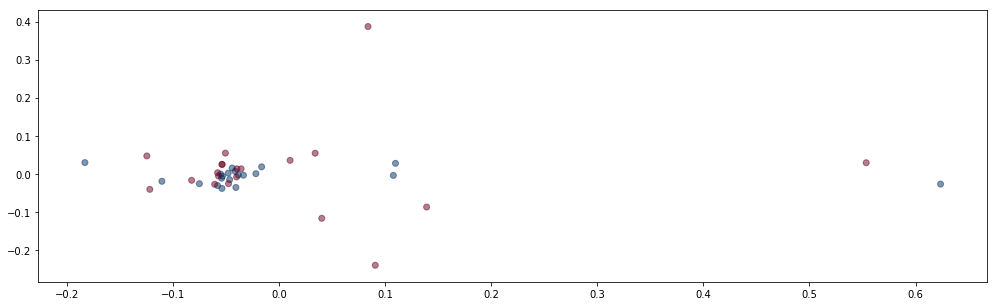

In [63]:
X = np.concatenate((jazz_beats_truncated, classical_beats_truncated), axis=0)
X = skl.decomposition.PCA(n_components=2).fit_transform(X)


y = np.concatenate((np.repeat('Jazz', 20), np.repeat('Classical', 20)))
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

In [65]:
print(np.mean(np.std(jazz_beats_truncated, axis=1)))
print(np.mean(np.std(classical_beats_truncated, axis=1)))

0.0226260160260267
0.0349492620062453
